# Liquid Neural Network (CfC) for Solar Power Prediction

This notebook implements a Liquid Neural Network using the ncps library (Closed-form Continuous-time) to predict solar output.

## Approach:
1. Load existing DataFrame with weather and solar data
2. Create sliding window sequences for RNN input
3. Build CfC-based model
4. Train with MSELoss and Adam optimizer
5. Predict PV(W)_error and reconstruct final PV(W)
6. Evaluate with RMSE and R2 score

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import ncps
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import os
import datetime
from IPython.display import display, Markdown

In [2]:
# Setup paths and configuration
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
print("Data directory set to:", DATA_DIR)
print("Model directory set to:", MODEL_DIR)

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/
Model directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/model/


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load training and testing data
df_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

print(f"Training data shape: {df_train.shape}")
print(f"Testing data shape: {df_test.shape}")

Training data shape: (2192, 85)
Testing data shape: (2194, 85)


In [5]:
# Define feature columns (weather features)
feature_cols = [
    'Temperature(C)',
    'Humidity(%)',
    'Sunshine Duration',
    'Precipitation(mm)',
    'Dew Point(C)',
    'Wind Direction(deg)',
    'Wind Speed(m/s)',
    'Pressure(hPa)',
    'Wind Cooling',
    'Total_Power_ClearSky_Output(W)',
    'Month_Sin',
    'DayOfYear_Sin',
    'HourOfDay_Sin',
    'Month_Cos',
    'DayOfYear_Cos',
    'HourOfDay_Cos',
    'Dew Point(C)_Lag1',
    'Temp_Lag1',
    'Humidity_Lag1',
    'WindSpeed_Lag1',
    'Dew Point(C)_Lag24',
    'Temp_Lag24',
    'Humidity_Lag24',
    'WindSpeed_Lag24',
    'Total_Power_ClearSky_Output(W)_Lag1',
    'Total_Power_ClearSky_Output(W)_Lag24'
]

# Add level 2 features
level2_features = [col for col in df_train.columns if col.startswith('level2_')]
feature_cols += level2_features

# Target column
target_col = 'PV(W)_error'  # This is the residual: Actual PV - ClearSky Output

print(f"Number of features: {len(feature_cols)}")
print(f"Target column: {target_col}")

Number of features: 31
Target column: PV(W)_error


In [6]:
# Function to create sliding window sequences for RNN
def create_sequences(data, target, sequence_length=24):
    """
    Convert tabular data into 3D sequences for RNN input.
    
    Args:
        data: DataFrame or array of features
        target: Series or array of target values
        sequence_length: Number of time steps in each sequence
    
    Returns:
        X_seq: Array of shape (num_sequences, sequence_length, num_features)
        y_seq: Array of shape (num_sequences,)
        clearsky_seq: Array of clearsky values for inverse transform
    """
    X = data.values if isinstance(data, pd.DataFrame) else data
    y = target.values if isinstance(target, pd.Series) else target
    
    # Get clearsky output for inverse transformation
    if isinstance(data, pd.DataFrame):
        clearsky_idx = data.columns.get_loc('Total_Power_ClearSky_Output(W)')
        clearsky = X[:, clearsky_idx]
    else:
        clearsky = X[:, 9]  # Index of Total_Power_ClearSky_Output(W)
    
    num_sequences = len(X) - sequence_length + 1
    X_seq = np.zeros((num_sequences, sequence_length, X.shape[1]))
    y_seq = np.zeros(num_sequences)
    clearsky_seq = np.zeros(num_sequences)
    
    for i in range(num_sequences):
        X_seq[i] = X[i:i + sequence_length]
        y_seq[i] = y[i + sequence_length - 1]  # Predict the target at the end of the sequence window
        clearsky_seq[i] = clearsky[i + sequence_length - 1]
    
    return X_seq, y_seq, clearsky_seq

print("Sequence creation function defined.")

Sequence creation function defined.


In [7]:
# Prepare data
SEQUENCE_LENGTH = 24  # 24 hours of historical data

# Extract features and target
X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]

print("Original shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Original shapes:
X_train: (2192, 31), y_train: (2192,)
X_test: (2194, 31), y_test: (2194,)


In [8]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features normalized with StandardScaler")

Features normalized with StandardScaler


In [9]:
# Create sequences
X_train_seq, y_train_seq, clearsky_train = create_sequences(
    X_train, y_train, SEQUENCE_LENGTH
)
X_test_seq, y_test_seq, clearsky_test = create_sequences(
    X_test, y_test, SEQUENCE_LENGTH
)

print("\nSequence shapes:")
print(f"X_train_seq: {X_train_seq.shape}")
print(f"y_train_seq: {y_train_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}")
print(f"y_test_seq: {y_test_seq.shape}")


Sequence shapes:
X_train_seq: (2169, 24, 31)
y_train_seq: (2169,)
X_test_seq: (2171, 24, 31)
y_test_seq: (2171,)


In [10]:
# Apply scaling to sequences
# Reshape to 2D for scaling, then back to 3D
n_train = X_train_seq.shape[0]
n_test = X_test_seq.shape[0]

X_train_seq_2d = X_train_seq.reshape(-1, X_train_seq.shape[2])
X_test_seq_2d = X_test_seq.reshape(-1, X_test_seq.shape[2])

X_train_seq_scaled = scaler.transform(X_train_seq_2d).reshape(n_train, SEQUENCE_LENGTH, -1)
X_test_seq_scaled = scaler.transform(X_test_seq_2d).reshape(n_test, SEQUENCE_LENGTH, -1)

print("Sequences normalized")

Sequences normalized


c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA-programming-for-data-analytics\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA-programming-for-data-analytics\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_seq).to(device)

print("Data converted to PyTorch tensors")

Data converted to PyTorch tensors


In [12]:
# Define the CfC-based Liquid Neural Network model
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        """
        Liquid Neural Network using CfC (Closed-form Continuous-time) layer.
        
        Architecture: Input -> CfC Layer -> Output
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units in CfC layer
            output_size: Number of output values (1 for regression)
        """
        super(LiquidNeuralNetwork, self).__init__()
        
        # Create wiring for the CfC network
        # AutoNCP automatically creates a sparse wiring architecture
        # that maps directly to the output dimension
        wiring = AutoNCP(hidden_size, output_size)
        
        # CfC layer - the core of the Liquid Neural Network
        # This already includes the output projection
        self.cfc = CfC(input_size, wiring, batch_first=True)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
        
        Returns:
            Output tensor of shape (batch_size,)
        """
        # Pass through CfC layer
        # Returns output for all time steps: (batch, seq_len, output_dim)
        cfc_out, _ = self.cfc(x)
        
        # Take the output from the last time step
        # Shape: (batch, output_dim)
        last_output = cfc_out[:, -1, :]
        
        # Squeeze to get shape (batch,) for single output
        return last_output.squeeze()

print("LiquidNeuralNetwork model class defined")

LiquidNeuralNetwork model class defined


In [13]:
# Initialize model
input_size = X_train_seq_scaled.shape[2]
hidden_size = 64
output_size = 1

model = LiquidNeuralNetwork(input_size, hidden_size, output_size).to(device)

print(f"Model initialized with:")
print(f"  Input size: {input_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Output size: {output_size}")
print(f"\nModel architecture:")
print(model)

Model initialized with:
  Input size: 31
  Hidden size: 64
  Output size: 1

Model architecture:
LiquidNeuralNetwork(
  (cfc): CfC(
    (rnn_cell): WiredCfCCell(
      (layer_0): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=69, out_features=38, bias=True)
        (ff2): Linear(in_features=69, out_features=38, bias=True)
        (time_a): Linear(in_features=69, out_features=38, bias=True)
        (time_b): Linear(in_features=69, out_features=38, bias=True)
      )
      (layer_1): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=63, out_features=25, bias=True)
        (ff2): Linear(in_features=63, out_features=25, bias=True)
        (time_a): Linear(in_features=63, out_features=25, bias=True)
        (time_b): Linear(in_features=63, out_features=25, bias=True)
      )
      (layer_2): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=26, out_featur

In [14]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function: MSELoss")
print("Optimizer: Adam (lr=0.001)")

Loss function: MSELoss
Optimizer: Adam (lr=0.001)


In [15]:
# Training loop
num_epochs = 100
batch_size = 64

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training for {num_epochs} epochs with batch size {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training for 100 epochs with batch size 64
Number of training batches: 34
Number of test batches: 34


In [16]:
# Training history
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Starting training...
Epoch [10/100], Train Loss: 3707998.2279, Val Loss: 3203759.5551
Epoch [20/100], Train Loss: 3707935.0735, Val Loss: 3203758.2243
Epoch [30/100], Train Loss: 3713896.3015, Val Loss: 3203758.0349
Epoch [40/100], Train Loss: 3710903.5662, Val Loss: 3203757.7298
Epoch [50/100], Train Loss: 3712956.5074, Val Loss: 3203757.6195
Epoch [60/100], Train Loss: 3709571.9926, Val Loss: 3203757.6158
Epoch [70/100], Train Loss: 3710365.3750, Val Loss: 3203757.5772
Epoch [80/100], Train Loss: 3708851.5147, Val Loss: 3203757.5772
Epoch [90/100], Train Loss: 3714965.7647, Val Loss: 3203757.5772
Epoch [100/100], Train Loss: 3712927.8162, Val Loss: 3203757.5680
Training completed!


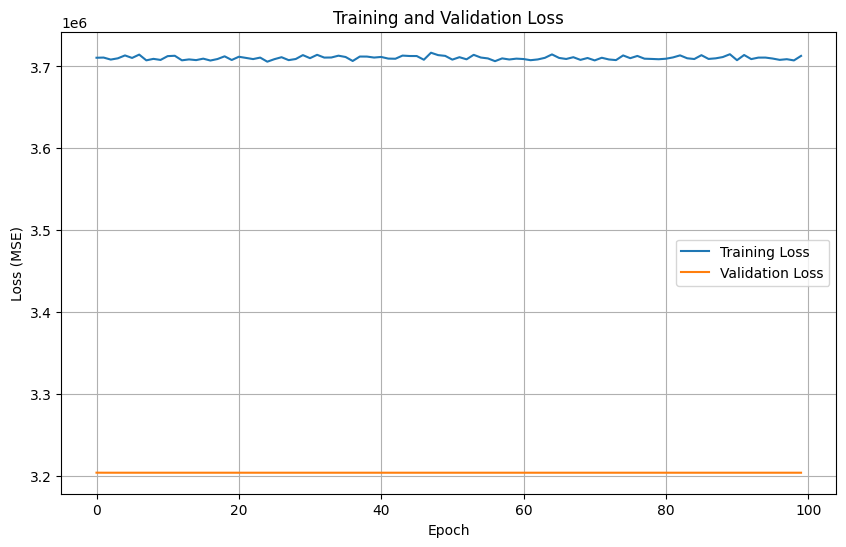

In [17]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Make predictions
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()
    y_test_pred = model(X_test_tensor).cpu().numpy()

y_train_actual = y_train_seq
y_test_actual = y_test_seq

print("Predictions generated")
print(f"Train predictions shape: {y_train_pred.shape}")
print(f"Test predictions shape: {y_test_pred.shape}")

Predictions generated
Train predictions shape: (2169,)
Test predictions shape: (2171,)


In [19]:
# Inverse transform: Add predictions back to Total_Power_ClearSky_Output(W)
# PV(W) = PV(W)_error + Total_Power_ClearSky_Output(W)

y_train_pvw_pred = y_train_pred + clearsky_train
y_train_pvw_actual = y_train_actual + clearsky_train

y_test_pvw_pred = y_test_pred + clearsky_test
y_test_pvw_actual = y_test_actual + clearsky_test

# Clip negative predictions to 0 (solar power cannot be negative)
y_train_pvw_pred = np.clip(y_train_pvw_pred, 0, None)
y_test_pvw_pred = np.clip(y_test_pvw_pred, 0, None)

print("Inverse transformation completed")
print("Negative predictions clipped to 0")

Inverse transformation completed
Negative predictions clipped to 0


In [20]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, R2, and normalized metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Normalized metrics
    normalization_factor = np.max(y_true) - np.min(y_true)
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    
    # Accuracy score
    accuracy_score = 1 - (mae / np.mean(y_true))
    
    return rmse, mae, r2, n_rmse, n_mae, accuracy_score

# Calculate metrics for PV(W)_error predictions
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(
    y_train_actual, y_train_pred
)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(
    y_test_actual, y_test_pred
)

# Calculate metrics for reconstructed PV(W)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw = calculate_metrics(
    y_train_pvw_actual, y_train_pvw_pred
)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw = calculate_metrics(
    y_test_pvw_actual, y_test_pvw_pred
)

print("Metrics calculated")

Metrics calculated


In [21]:
# Display metrics for PV(W)_error
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)

display(Markdown(f"### Liquid Neural Network Performance Metrics - PV(W)_error\n" + mk_string))

### Liquid Neural Network Performance Metrics - PV(W)_error
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 1926.30              | 1790.81              |
| MAE          | 1549.36              | 1434.60              |
| R2           | -1.6906              | -1.6107              |
| N-RMSE (%)   | 31.1790              | 28.4745              |
| N-MAE (%)    | 25.0779              | 22.8107              |
| Accuracy (%) | 201.4022              | 201.9167              |

In [22]:
# Display metrics for reconstructed PV(W)
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100
)

display(Markdown(f"### Liquid Neural Network Performance Metrics - Reconstructed PV(W)\n" + mk_string))

### Liquid Neural Network Performance Metrics - Reconstructed PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 1926.30              | 1790.81              |
| MAE          | 1549.36              | 1434.60              |
| R2           | -0.8440              | -0.6672              |
| N-RMSE (%)   | 34.2829              | 31.9413              |
| N-MAE (%)    | 27.5744              | 25.5878              |
| Accuracy (%) | 11.7506              | 24.5706              |

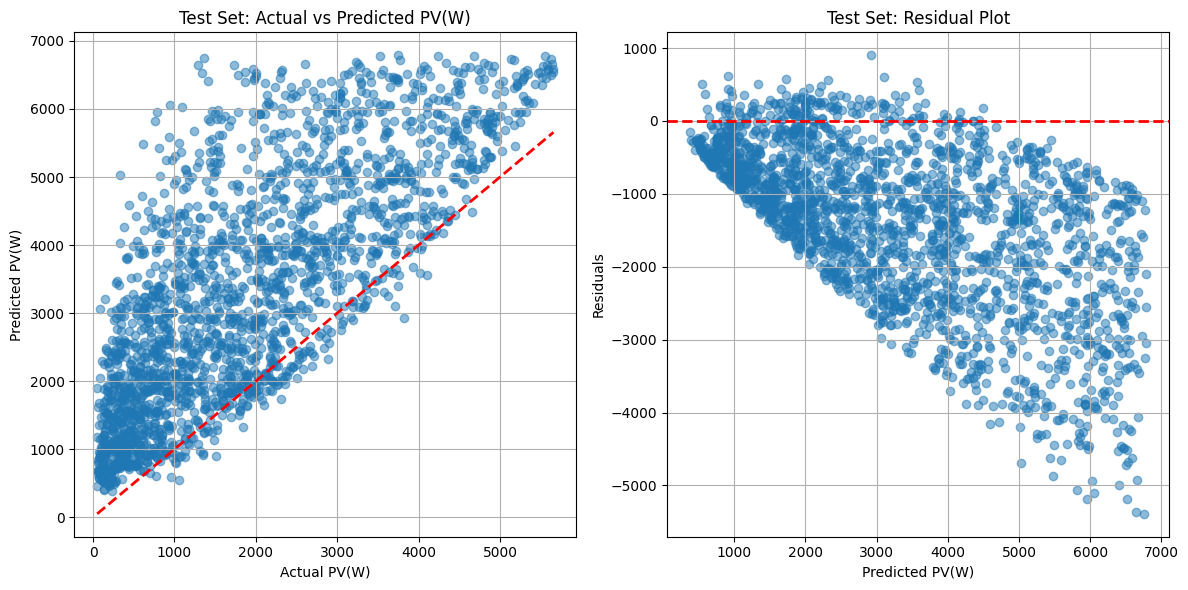

In [23]:
# Plot actual vs predicted for test set (PV(W))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_pvw_actual, y_test_pvw_pred, alpha=0.5)
plt.plot([y_test_pvw_actual.min(), y_test_pvw_actual.max()], 
         [y_test_pvw_actual.min(), y_test_pvw_actual.max()], 
         'r--', lw=2)
plt.xlabel('Actual PV(W)')
plt.ylabel('Predicted PV(W)')
plt.title('Test Set: Actual vs Predicted PV(W)')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = y_test_pvw_actual - y_test_pvw_pred
plt.scatter(y_test_pvw_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted PV(W)')
plt.ylabel('Residuals')
plt.title('Test Set: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

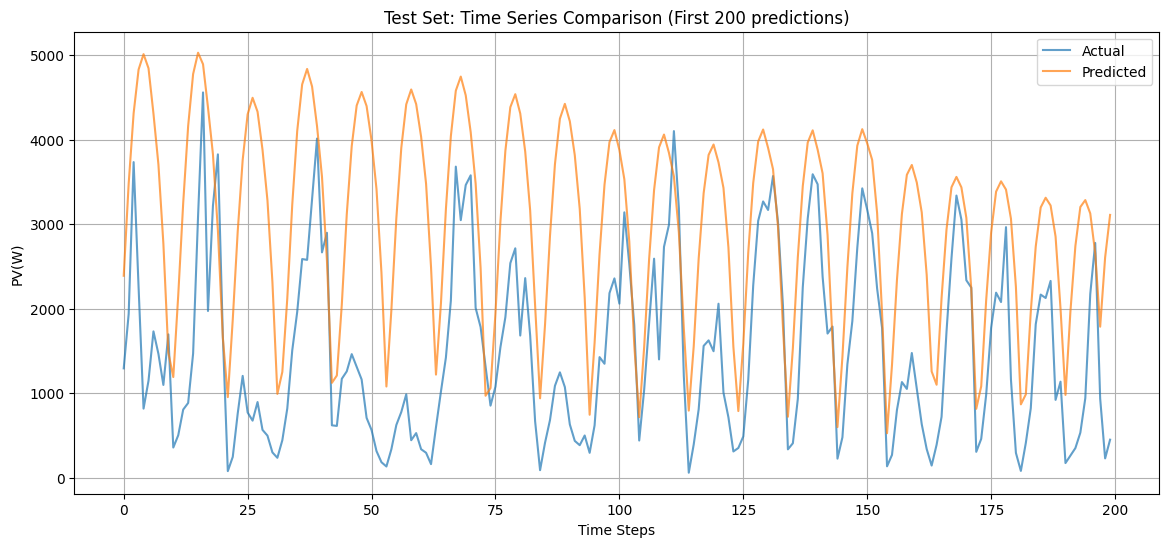

In [24]:
# Plot time series comparison (first 200 predictions)
plt.figure(figsize=(14, 6))
n_samples = min(200, len(y_test_pvw_actual))
plt.plot(range(n_samples), y_test_pvw_actual[:n_samples], label='Actual', alpha=0.7)
plt.plot(range(n_samples), y_test_pvw_pred[:n_samples], label='Predicted', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('PV(W)')
plt.title('Test Set: Time Series Comparison (First 200 predictions)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Save the model
model_path = f"{MODEL_DIR}/liquid_neural_network_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'sequence_length': SEQUENCE_LENGTH,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'feature_cols': feature_cols,
    'train_losses': train_losses,
    'val_losses': val_losses
}, model_path)

print(f"Model saved to: {model_path}")

Model saved to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/model//liquid_neural_network_model.pth


In [26]:
# Summary
summary = f"""
## Summary

### Model Architecture
- **Type**: Liquid Neural Network (CfC - Closed-form Continuous-time)
- **Input**: Weather features over 24-hour sliding windows
- **Architecture**: Input ({input_size} features) -> CfC Layer ({hidden_size} units) -> Linear Head -> Output (1 value)
- **Sequence Length**: {SEQUENCE_LENGTH} hours
- **Training Epochs**: {num_epochs}
- **Optimizer**: Adam (lr=0.001)
- **Loss Function**: MSELoss

### Performance on PV(W) Reconstruction
- **Test RMSE**: {test_rmse_pvw:.2f} W
- **Test MAE**: {test_mae_pvw:.2f} W
- **Test R²**: {test_r2_pvw:.4f}
- **Test Accuracy**: {test_accuracy_pvw*100:.2f}%

### Key Features
- Predicts residual error (PV(W)_error) and reconstructs final PV(W)
- Uses continuous-time neural computation for better temporal modeling
- Handles sequential dependencies in weather and solar data
- Automatically clips negative predictions to ensure physical validity
"""

display(Markdown(summary))


## Summary

### Model Architecture
- **Type**: Liquid Neural Network (CfC - Closed-form Continuous-time)
- **Input**: Weather features over 24-hour sliding windows
- **Architecture**: Input (31 features) -> CfC Layer (64 units) -> Linear Head -> Output (1 value)
- **Sequence Length**: 24 hours
- **Training Epochs**: 100
- **Optimizer**: Adam (lr=0.001)
- **Loss Function**: MSELoss

### Performance on PV(W) Reconstruction
- **Test RMSE**: 1790.81 W
- **Test MAE**: 1434.60 W
- **Test R²**: -0.6672
- **Test Accuracy**: 24.57%

### Key Features
- Predicts residual error (PV(W)_error) and reconstructs final PV(W)
- Uses continuous-time neural computation for better temporal modeling
- Handles sequential dependencies in weather and solar data
- Automatically clips negative predictions to ensure physical validity
